In [169]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
df = pd.read_csv('../_data/datasets/fedex_preprocessed.csv')

## Train / dev / test split

In [5]:
df_train = df.sample(frac=0.90, random_state=42)
df_dev_test = df.drop(df_train.index)
df_dev  = df_dev_test.sample(frac=0.5, random_state=42)
df_test = df_dev_test.drop(df_dev.index)

In [6]:
len(df_train), len(df_dev), len(df_test)

(27577895, 1532106, 1532105)

In [7]:
set(df_train.index).intersection(df_dev.index), set(df_dev.index).intersection(df_test.index)

(set(), set())

## Label encoding

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {col: LabelEncoder().fit(df[col]) \
                  for col in ['section', 'chapter', 'heading', 'hscode']}
for col in label_encoders:
    df_train[col + '_encoded'] = label_encoders[col].transform(df_train[col])
    df_dev[col + '_encoded'] = label_encoders[col].transform(df_dev[col])
    df_test[col + '_encoded'] = label_encoders[col].transform(df_test[col])

In [9]:
df_train.to_json('../_data/datasets/FedEx/fedex_train.json', orient='records', lines=True)
df_dev.to_json('../_data/datasets/FedEx/fedex_dev.json', orient='records', lines=True)
df_test.to_json('../_data/datasets/FedEx/fedex_test.json', orient='records', lines=True)

## Torchtext

In [10]:
import os
import torchtext
from torchtext import data
from torchtext import datasets

In [13]:
def load_datasets(folder_path, train_file, dev_file, test_file):
    TEXT = data.Field(sequential=True, lower=True, use_vocab=True)
    LABEL = data.Field(sequential=False, use_vocab=False)
    datafields = {
        'parsed_description': ('parsed_description', TEXT),
#         'description': ('description', TEXT),
#         'hscode': ('hscode', LABEL),
#         'heading': ('heading', LABEL),
#         'chapter': ('chapter', LABEL),        
#         'section': ('section', LABEL),
        'hscode_encoded': ('hscode_encoded', LABEL),
#         'heading_encoded': ('heading_encoded', LABEL),
#         'chapter_encoded': ('chapter_encoded', LABEL),
#         'section_encoded': ('section_encoded', LABEL)
    }
    train, dev = data.TabularDataset.splits(path=folder_path, train=train_file,
                                            validation=dev_file, format='json', 
                                            fields=datafields)
    test = data.TabularDataset(path=os.path.join(folder_path, test_file), format='json',
                              fields=datafields)
    fastText = torchtext.vocab.FastText(language='en', 
                    cache='/home/raduviri/Documents/chana-nmt/.vector_cache')
    TEXT.build_vocab(train, vectors=fastText)
    return train, dev, test, TEXT

In [14]:
train, dev, test, TEXT = load_datasets('../_data/datasets/FedEx', 'fedex_train.json',
                                      'fedex_dev.json', 'fedex_test.json')

Loading vectors from /home/raduviri/Documents/chana-nmt/.vector_cache/wiki.en.vec.pt


## Bucket iterators

In [15]:
batch_size = 256

In [16]:
train_buckets, dev_buckets, test_buckets = data.BucketIterator.splits(
    (train, dev, test), batch_sizes=(batch_size, batch_size, batch_size), 
    device=0, sort_key=lambda x: len(x.parsed_description), repeat=True)

In [17]:
train_iter = iter(train_buckets)
dev_iter = iter(dev_buckets)
test_iter = iter(test_buckets)

## Model

In [18]:
import torch
import torch.nn as nn
from torch import optim
from LSTM_model import LSTMClassifier, train_step

In [19]:
USE_CUDA = True
embedding_matrix = TEXT.vocab.vectors
vocab_size = embedding_matrix.shape[0]
embedding_size = embedding_matrix.shape[1]
hidden_size = 512
label_size = int(max(set(example.hscode_encoded for example in train.examples + dev.examples + test.examples)) + 1)
n_layers = 2
dropout_p = 0.2

In [20]:
model = LSTMClassifier(vocab_size=vocab_size, embedding_size=embedding_size,
                       hidden_size=hidden_size, label_size=label_size, 
                       batch_size=batch_size, n_layers=n_layers, 
                       dropout_p=dropout_p, 
                       pretrained_embeddings=embedding_matrix,
                       USE_CUDA=USE_CUDA)
if USE_CUDA:
    model = model.cuda()

In [21]:
learning_rate = 3e-4
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                       lr=learning_rate)
criterion = nn.NLLLoss()

## Training

In [22]:
from training_utils import time_since, as_minutes, plot_losses
import time
n_epochs = 120000
plot_every = 100
print_every = 200
validate_every = 1000
train_losses = []
validation_losses = []
print_loss_total = 0
plot_loss_total = 0

In [24]:
start = time.time()
for epoch in range(1, n_epochs + 1):
    train_batch = next(train_iter)
    loss = train_step(train_batch.parsed_description, train_batch.hscode_encoded, 
                      model, optimizer, criterion, USE_CUDA, train=True)
    print_loss_total += loss
    plot_loss_total += loss
    
    if epoch % print_every == 0:
        print_loss_avg = print_loss_total / print_every
        print_loss_total = 0
        print(f'{time_since(start, epoch / n_epochs)} ({epoch} {epoch / n_epochs * 100:.2f}%) train_loss: {print_loss_avg:.4f}', end=' ')
        
    if epoch % plot_every == 0:
        plot_loss_avg = plot_loss_total / plot_every
        train_losses.append(plot_loss_avg)
        plot_loss_total = 0
    
    if epoch % validate_every == 0:
        dev_batch = next(dev_iter)
        eval_loss = train_step(dev_batch.parsed_description, dev_batch.hscode_encoded, 
                          model, optimizer, criterion, USE_CUDA, train=False)        
        validation_losses.append(eval_loss)
        print(f'- val_loss: {eval_loss:.4f}', end='')
    
    if epoch % print_every == 0:
        print()

0m 55s (- 557m 12s) (200 0.17%) train_loss: 4.9513 
1m 0s (- 303m 46s) (400 0.33%) train_loss: 3.7844 
1m 5s (- 218m 45s) (600 0.50%) train_loss: 3.2441 
1m 10s (- 176m 0s) (800 0.67%) train_loss: 2.9202 
1m 15s (- 150m 34s) (1000 0.83%) train_loss: 2.6992 - val_loss: 1.7771
1m 27s (- 144m 23s) (1200 1.00%) train_loss: 2.5175 
1m 32s (- 130m 41s) (1400 1.17%) train_loss: 2.3937 
1m 37s (- 120m 24s) (1600 1.33%) train_loss: 2.3244 
1m 42s (- 112m 14s) (1800 1.50%) train_loss: 2.2366 
1m 47s (- 105m 41s) (2000 1.67%) train_loss: 2.1632 - val_loss: 1.7985
1m 52s (- 100m 11s) (2200 1.83%) train_loss: 2.1163 
1m 57s (- 95m 43s) (2400 2.00%) train_loss: 2.0727 
2m 2s (- 92m 0s) (2600 2.17%) train_loss: 2.0069 
2m 7s (- 88m 44s) (2800 2.33%) train_loss: 1.9948 
2m 12s (- 85m 55s) (3000 2.50%) train_loss: 1.9606 - val_loss: 1.6303
2m 17s (- 83m 27s) (3200 2.67%) train_loss: 1.9373 
2m 22s (- 81m 12s) (3400 2.83%) train_loss: 1.9057 
2m 27s (- 79m 13s) (3600 3.00%) train_loss: 1.8646 
2m 32s (-

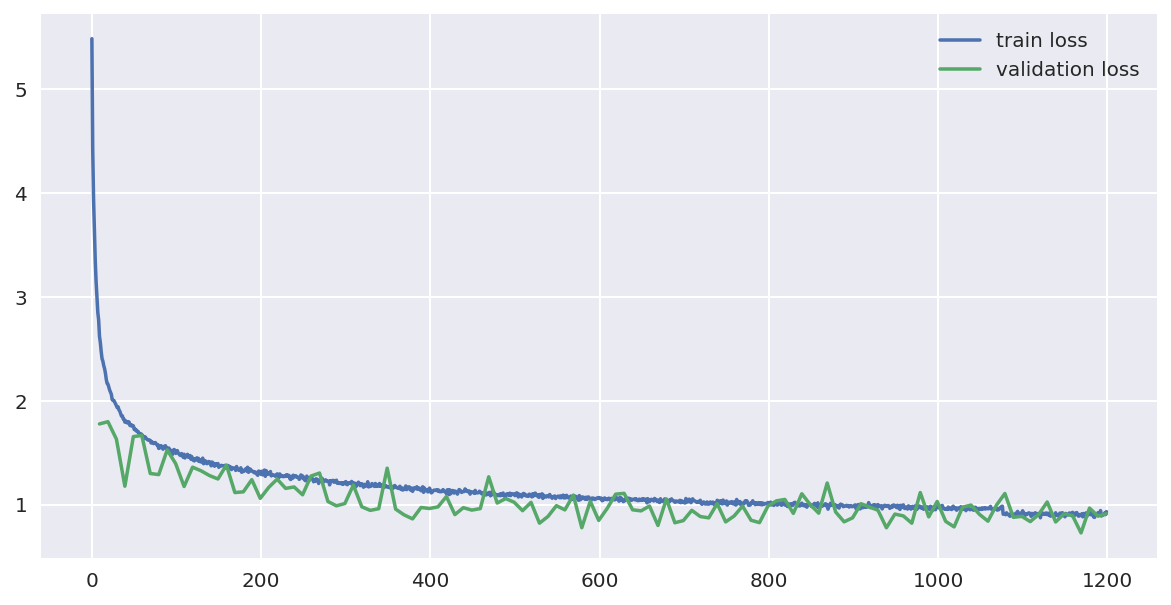

In [25]:
# 120,000 iterations, 256 batch size
plot_losses(train_losses, validation_losses, validate_every // plot_every)

In [26]:
torch.save(model.state_dict(), '../_data/datasets/FedEx/hscode_LSTM_weights.pt')

In [27]:
torch.save(model, '../_data/datasets/FedEx/hscode_LSTM')

## Evaluation

In [28]:
from LSTM_model import evaluate

def get_predictions(data_iter, n_batches):
    all_predicted = []
    all_targets = []
    for idx in range(n_batches):
        batch = next(data_iter)
        output = evaluate(batch.parsed_description, model, USE_CUDA)
        _, predicted = torch.max(output.data, 1)
        all_predicted.extend(predicted)
        all_targets.extend(batch.hscode_encoded.data)
        if idx % (20 * 5) == 0: 
            print(idx * 128, end=' ')
    return all_predicted, all_targets

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

#### Dev

In [30]:
targets, predicted = get_predictions(dev_iter, len(dev.examples) // batch_size)

0 12800 25600 38400 51200 64000 76800 89600 102400 115200 128000 140800 153600 166400 179200 192000 204800 217600 230400 243200 256000 268800 281600 294400 307200 320000 332800 345600 358400 371200 384000 396800 409600 422400 435200 448000 460800 473600 486400 499200 512000 524800 537600 550400 563200 576000 588800 601600 614400 627200 640000 652800 665600 678400 691200 704000 716800 729600 742400 755200 

In [31]:
targets = label_encoders['hscode'].inverse_transform(targets)
predicted = label_encoders['hscode'].inverse_transform(predicted)

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [32]:
accuracy_score(targets, predicted)

0.7630348924503052

In [33]:
print(classification_report(targets, predicted))

             precision    recall  f1-score   support

      10690       0.00      0.00      0.00         0
      21020       0.00      0.00      0.00         1
      30559       0.00      0.00      0.00         0
      32000       0.00      0.00      0.00         0
      40299       0.00      0.00      0.00         0
      40590       0.00      0.00      0.00         0
      40900       0.00      0.00      0.00         0
      40901       0.00      0.00      0.00         0
      41000       1.00      0.83      0.91         6
      50510       0.00      0.00      0.00         0
      50800       0.00      0.00      0.00         0
      51199       0.35      0.50      0.41        16
      60110       0.00      0.00      0.00         0
      60319       0.00      0.00      0.00         0
      60490       0.75      0.75      0.75         4
      71231       0.00      0.00      0.00         0
      71290       0.00      0.00      0.00         0
      71333       0.17      0.20      0.18   

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


### Test

In [34]:
targets, predicted = get_predictions(test_iter, len(dev.examples) // batch_size)

0 12800 25600 38400 51200 64000 76800 89600 102400 115200 128000 140800 153600 166400 179200 192000 204800 217600 230400 243200 256000 268800 281600 294400 307200 320000 332800 345600 358400 371200 384000 396800 409600 422400 435200 448000 460800 473600 486400 499200 512000 524800 537600 550400 563200 576000 588800 601600 614400 627200 640000 652800 665600 678400 691200 704000 716800 729600 742400 755200 

In [35]:
targets = label_encoders['hscode'].inverse_transform(targets)
predicted = label_encoders['hscode'].inverse_transform(predicted)

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [36]:
accuracy_score(targets, predicted)

0.7635230406082888

In [37]:
print(classification_report(targets, predicted))

             precision    recall  f1-score   support

      21020       0.00      0.00      0.00         1
      21099       0.00      0.00      0.00         0
      40299       0.00      0.00      0.00         0
      40410       0.00      0.00      0.00         1
      40690       0.00      0.00      0.00         0
      40899       0.00      0.00      0.00         0
      40900       0.00      0.00      0.00         0
      41000       1.00      1.00      1.00         1
      51199       0.57      0.55      0.56        22
      60110       0.00      0.00      0.00         0
      60319       0.00      0.00      0.00         0
      60490       0.50      1.00      0.67         2
      71291       0.00      0.00      0.00         0
      71333       0.00      0.00      0.00         6
      71340       0.36      0.43      0.39        23
      80212       0.00      0.00      0.00         0
      80410       0.00      0.00      0.00         0
      81350       0.00      0.00      0.00   

/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/raduviri/anaconda3/envs/chana/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Top k

In [40]:
def get_topk_predictions(data_iter, n_batches, k=3):
    all_predicted = []
    all_targets = []
    for idx in range(n_batches):
        batch = next(data_iter)
        output = evaluate(batch.parsed_description, model, USE_CUDA)
        _, predicted = torch.topk(output.data, k, 1)
        all_predicted.extend(predicted)
        all_targets.extend(batch.hscode_encoded.data)
        if idx % (20 * 5) == 0: 
            print(idx * 128, end=' ')
    return all_predicted, all_targets

### Dev - Top 3

In [41]:
predicted, targets = get_topk_predictions(dev_iter, len(dev.examples) // batch_size, k=3)

0 12800 25600 38400 51200 64000 76800 89600 102400 115200 128000 140800 153600 166400 179200 192000 204800 217600 230400 243200 256000 268800 281600 294400 307200 320000 332800 345600 358400 371200 384000 396800 409600 422400 435200 448000 460800 473600 486400 499200 512000 524800 537600 550400 563200 576000 588800 601600 614400 627200 640000 652800 665600 678400 691200 704000 716800 729600 742400 755200 

In [42]:
best_predictions = [target if target in candidates else candidates[0] \
                    for candidates, target in zip(predicted, targets)]

In [43]:
accuracy_score(targets, best_predictions)

0.8959695792668995

### Dev - Top 5

In [44]:
predicted, targets = get_topk_predictions(dev_iter, len(dev.examples) // batch_size, k=5)

0 12800 25600 38400 51200 64000 76800 89600 102400 115200 128000 140800 153600 166400 179200 192000 204800 217600 230400 243200 256000 268800 281600 294400 307200 320000 332800 345600 358400 371200 384000 396800 409600 422400 435200 448000 460800 473600 486400 499200 512000 524800 537600 550400 563200 576000 588800 601600 614400 627200 640000 652800 665600 678400 691200 704000 716800 729600 742400 755200 

In [45]:
best_predictions = [target if target in candidates else candidates[0] \
                    for candidates, target in zip(predicted, targets)]

In [46]:
accuracy_score(targets, best_predictions)

0.9260932858961387

# Interface

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [143]:
import re
import torch
import torchtext

from pipeline_utils import section_labels
from pipeline_utils import section_map

In [ ]:
USE_CUDA = True
batch_size = 256

In [ ]:
model = torch.load('../_data/datasets/FedEx/hscode_LSTM')

In [48]:
fastText = torchtext.vocab.FastText(language='en', 
                cache='/home/raduviri/Documents/chana-nmt/.vector_cache')
vocab = fastText.stoi

Loading vectors from /home/raduviri/Documents/chana-nmt/.vector_cache/wiki.en.vec.pt


In [51]:
df.hscode.nunique()

3762

In [148]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [153]:
def evaluate_sentence(sentence, k=3):
    pattern = re.compile('[^a-z]+', re.UNICODE)
    sentence = pattern.sub(' ', sentence.lower()).strip()
    sentence = ' '.join([w for w in sentence.split() if len(w)>=2 and w in vocab])
    input_batch = TEXT.process([TEXT.preprocess(sentence)], None, False)
    model.hidden = model.init_hidden(1)
    output = model(input_batch)
    probabilities, predicted = torch.topk(output.data, k, 1)
    results = pd.DataFrame()
    results['Predicted HSCode'] = label_encoders['hscode'].inverse_transform(predicted)[0]
    results['Probability'] = np.exp(probabilities)[0]
    results['Heading'] = results['Predicted HSCode'].apply(lambda x: str(x)[:4])
    results['Chapter'] = results['Predicted HSCode'].apply(lambda x: str(x)[:2])
    results['Section'] = results['Chapter'].apply(lambda x: section_map[int(x)])
    results['Section Label'] = results['Section'].apply(lambda x: section_labels[int(x)])
    return results

In [187]:
evaluate_sentence("Conella End Table with Faux Marble Top metal frame", k=3)

,Predicted HSCode,Probability,Heading,Chapter,Section,Section Label
0,940389,0.594643,9403,94,20,MISCELLANEOUS MANUFACTURED ARTICLES
1,940360,0.386915,9403,94,20,MISCELLANEOUS MANUFACTURED ARTICLES
2,940320,0.003413,9403,94,20,MISCELLANEOUS MANUFACTURED ARTICLES


In [184]:
evaluate_sentence("Aiden Coffee Table wooden top metal frame", k=3)

,Predicted HSCode,Probability,Heading,Chapter,Section,Section Label
0,940389,0.825232,9403,94,20,MISCELLANEOUS MANUFACTURED ARTICLES
1,940360,0.157521,9403,94,20,MISCELLANEOUS MANUFACTURED ARTICLES
2,940320,0.003413,9403,94,20,MISCELLANEOUS MANUFACTURED ARTICLES


In [185]:
evaluate_sentence("Aiden Coffee Table ", k=3)

,Predicted HSCode,Probability,Heading,Chapter,Section,Section Label
0,940360,0.542467,9403,94,20,MISCELLANEOUS MANUFACTURED ARTICLES
1,940389,0.445433,9403,94,20,MISCELLANEOUS MANUFACTURED ARTICLES
2,940161,0.004010,9401,94,20,MISCELLANEOUS MANUFACTURED ARTICLES


In [179]:
evaluate_sentence("Winflo 30\" 400 CFM Convertible  Wall Mount Range Hood with Carbon Filters", k=3)

,Predicted HSCode,Probability,Heading,Chapter,Section,Section Label
0,841480,0.784590,8414,84,16,MACHINERY AND MECHANICAL APPLIANCES; ELECTRICA...
1,841460,0.211661,8414,84,16,MACHINERY AND MECHANICAL APPLIANCES; ELECTRICA...
2,850980,0.001854,8509,85,16,MACHINERY AND MECHANICAL APPLIANCES; ELECTRICA...


In [183]:
%time evaluate_sentence("Peshtemal Turkish Towel, Gray", k=3)

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 10.3 ms


,Predicted HSCode,Probability,Heading,Chapter,Section,Section Label
0,630291,0.963892,6302,63,11,TEXTILES AND TEXTILE ARTICLES
1,630260,0.007869,6302,63,11,TEXTILES AND TEXTILE ARTICLES
2,630790,0.005605,6307,63,11,TEXTILES AND TEXTILE ARTICLES


In [188]:
evaluate_sentence("Anne klein palm springs 28-inch hardside spinner upright suitcase", k=3)

,Predicted HSCode,Probability,Heading,Chapter,Section,Section Label
0,420219,0.851005,4202,42,8,"RAW HIDES AND SKINS, LEATHER, FURSKINS AND ART..."
1,420292,0.143869,4202,42,8,"RAW HIDES AND SKINS, LEATHER, FURSKINS AND ART..."
2,420212,0.004489,4202,42,8,"RAW HIDES AND SKINS, LEATHER, FURSKINS AND ART..."


In [177]:
evaluate_sentence("Paris Wall Light, Black, Small", k=3)

,Predicted HSCode,Probability,Heading,Chapter,Section,Section Label
0,940540,0.971749,9405,94,20,MISCELLANEOUS MANUFACTURED ARTICLES
1,940550,0.004570,9405,94,20,MISCELLANEOUS MANUFACTURED ARTICLES
2,970300,0.003935,9703,97,21,"WORKS OF ART, COLLECTORS' PIECES AND ANTIQUES"


In [176]:
evaluate_sentence("ZLINE 2PCEXT-597i, 2-36\" Chimney Extensions for 10' - 12' Ceilings", k=3)

,Predicted HSCode,Probability,Heading,Chapter,Section,Section Label
0,732690,0.230328,7326,73,15,BASE METALS AND ARTICLES OF BASE METAL
1,732190,0.104649,7321,73,15,BASE METALS AND ARTICLES OF BASE METAL
2,730890,0.099825,7308,73,15,BASE METALS AND ARTICLES OF BASE METAL


In [168]:
evaluate_sentence("	Oscar Blandi 4.2-ounce Braid Paste", k=5)

,Predicted HSCode,Probability,Heading,Chapter,Section,Section Label
0,330590,0.977835,3305,33,6,PRODUCTS OF THE CHEMICAL OR ALLIED INDUSTRIES
1,901910,0.003574,9019,90,18,"OPTICAL, PHOTOGRAPHIC, CINEMATOGRAPHIC, MEASUR..."
2,670419,0.002478,6704,67,12,"FOOTWEAR, HEADGEAR, UMBRELLAS, SUN UMBRELLAS, ..."
3,330499,0.001782,3304,33,6,PRODUCTS OF THE CHEMICAL OR ALLIED INDUSTRIES
4,732393,0.001082,7323,73,15,BASE METALS AND ARTICLES OF BASE METAL


In [167]:
df_test[df_test.status==4].sample(5)

,id,description,hscode,heading,chapter,section,status,name,parsed_description,section_encoded,chapter_encoded,heading_encoded,hscode_encoded
455728,40662,Naples White Queen Headboard,940390,9403,94,20,4,Houzz/salida.json,naples white queen headboard,19,93,1164,3611
486962,1336820,Donco Kids Tent Twin Loft Bed With Slide Light...,940350,9403,94,20,4,Houzz/salida.json,kids tent twin loft bed with slide light espre...,19,93,1164,3601
3046496,8712125,"Bano Diseno Cloe Double Hook, Chrome",830250,8302,83,15,4,Houzz/salida.json,bano diseno cloe double hook chrome,14,82,895,2531
8618602,10749032,Oscar Blandi 4.2-ounce Braid Paste,330590,3305,33,6,4,Overstock/MB_Overstock.json,oscar blandi ounce braid paste,5,32,292,748
30216671,15961911,Safavieh Constellation Vintage Light Blue/ Mul...,570500,5705,57,11,4,Partners/MB_Overstock_4.json,constellation vintage light blue multi viscose...,10,56,568,1516
